# Team: KernelKnights

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time
from datetime import datetime
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import pywt
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

In [3]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

In [4]:
def plot_acf(data,num_lags,title,y_lim0=-1,y_lim1=1):
  # num_lags =  60
  acf_vals = acf(data, nlags=num_lags)
  plt.bar(range(num_lags), acf_vals[:num_lags])
  plt.ylim(y_lim0,y_lim1)
  plt.title(title)
  plt.show()
  print(np.argsort(np.abs(acf_vals)))

def plot_pacf(data,num_lags,title,y_lim0=-1,y_lim1=1):
  # num_lags =  60
  pacf_vals = pacf(data, nlags=num_lags)
  plt.bar(range(num_lags), pacf_vals[:num_lags])
  plt.ylim(y_lim0,y_lim1)
  plt.title(title)
  plt.show()
  print(np.argsort(np.abs(pacf_vals)))

In [5]:
def normalize(x):
  return (x-np.min(x))/(np.max(x)-np.min(x)) , np.max(x), np.min(x)

def unnormalize(x,mx,mn):
  x = np.array(x)
  return x*(mx-mn) + mn

In [6]:
def sliding_std(array, S, L):
    std_list = []
    i = 0
    while i + S <= len(array):
        window = array[i:i+S]
        std_list.append(np.std(window))
        i += L
    return std_list


def overlapping_concat(arr1, arr2, overlap_size):
    overlap_average = np.mean([arr1[-overlap_size:], arr2[:overlap_size]], axis=0)
    concatenated = np.concatenate([arr1[:-overlap_size], overlap_average, arr2[overlap_size:]])
    return concatenated


def pad(result:list,target_len):
    n = len(result)
    p = (n-target_len)//2
    # print((len(result),n,p,target_len))
    try:
      assert(len(result[p:-p])==target_len)
      return result[p:-p]
    except:
      return result[p+1:-p]


def rescale_std(result:list, S, L, og_shape):
    i = 0
    n = len(result)
    output = [result[0]]*S

    for r in result:
      new_output = [r]*S
      output = overlapping_concat(output,new_output,S-L)
    return pad(output.tolist(),og_shape)


def nth_order_difference(array, n):
    diff_order = n #+ n % 2
    diff_result = []
    array_len = len(array)

    for i in range(array_len - diff_order):
        diff_result.append(array[i + diff_order] - array[i])

    return np.array(diff_result)


def recover_signal(diff_array, baseline):
    recovered_signal = baseline.copy()
    for i in range(len(diff_array)):
        recovered_signal = np.append(recovered_signal, diff_array[i] + recovered_signal[i])

    return recovered_signal

def rolling_recovery(true_array, diff_array,base_index):
  return np.array([true_array[base_index+i]+diff_array[i] for i in range(len(diff_array))])

In [9]:
___rolling_predictions_bu = None
def rolling_arma(data,horizon,train_len,order):
  global ___rolling_predictions_bu
  # Unnorm data
  rolling_predictions = []
  # n = len(data_test)
  for train_end in tqdm(range(horizon)):
      # print(f"Completed {train_end+1}/{horizon}")
      _train_data = data[:(train_len+train_end)]
      # print(len(_train_data))
      # _train_data,mx,mn= normalize(_train_data)
      model = sm.tsa.arima.ARIMA(_train_data, order=order)
      model_fit = model.fit()
      pred = np.array(model_fit.forecast())[0]
      # print(f"--> {pred}")
      pred = pred #* (mx-mn) + mn
      rolling_predictions.append(pred)
      ___rolling_predictions_bu = rolling_predictions
  return np.array(rolling_predictions)


def rolling_MA(data,horizon,train_len,window):
  rolling_predictions = []
  # n = len(data_test)
  for train_end in tqdm(range(horizon)):
      # print(f"Completed {train_end+1}/{horizon}")
      _train_data = data[(train_len+train_end-window):(train_len+train_end)]
      pred = np.sum(_train_data)/window
      rolling_predictions.append(np.array(pred))
  return rolling_predictions

In [10]:
def apply_filter(data,filter=[1,0]):
    filter = np.array(filter)
    filtered_data = np.convolve(data, filter, mode='same')
    return filtered_data


def wavelet_denoise(data, wavelet='db4', level=1, threshold_mode='soft', threshold_value=0.1):
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(data, wavelet, level=level)

    # Threshold coefficients
    thresholded_coeffs = [pywt.threshold(detail, threshold_value, mode=threshold_mode) if i > 0 else detail
                          for i, detail in enumerate(coeffs)]

    # Reconstruct the denoised signal
    denoised_signal = pywt.waverec(thresholded_coeffs, wavelet)
    return denoised_signal


def low_pass_filter_four(signal, cutoff_frequency, verbose=False):
    # Compute Fourier Transform
    fourier_transform = np.fft.fft(signal)

    # Compute power spectrum
    power_spectrum = np.abs(fourier_transform) ** 2

    # Create a frequency domain
    frequency_domain = np.fft.fftfreq(len(signal))

    # Apply low-pass filter
    fourier_transform_filtered = fourier_transform.copy()
    fourier_transform_filtered[np.abs(frequency_domain) > cutoff_frequency] = 0

    # Compute inverse Fourier Transform to get the filtered signal
    filtered_signal = np.fft.ifft(fourier_transform_filtered)

    if verbose:
        plt.plot(np.abs(frequency_domain), power_spectrum, label='Power Spectrum')
        plt.axvline(x=cutoff_frequency, color='red', linestyle='--', label='Cutoff Frequency')
        plt.xlabel('Frequency')
        plt.ylabel('Power')
        plt.legend()
        plt.title('Power Spectrum with Cutoff Frequency')
        plt.show()

    return filtered_signal.real  # Return real part of the signal


def fft_power_denoiser(signal, threshold, verbose=False):
    # Compute Fourier Transform
    fourier_transform = np.fft.fft(signal)

    # Compute magnitude of the Fourier Transform
    magnitude = np.abs(fourier_transform)

    if verbose:
        plt.plot(magnitude, label='Fourier Transform Magnitude')
        plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
        plt.xlabel('Frequency')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.title('Fourier Transform with Threshold')
        plt.show()

    # Apply thresholding to remove high-frequency components
    fourier_transform[magnitude < threshold] = 0

    # Compute inverse Fourier Transform to obtain denoised signal
    denoised_signal = np.fft.ifft(fourier_transform)

    return denoised_signal.real  # Return real part of the signal


def kalman_denoising(signal, process_noise, measurement_noise):
    # Initial estimation of the state and covariance
    state_estimate = 0
    covariance_estimate = 1

    denoised_signal = []
    for measurement in signal:
        # Prediction step
        predicted_state = state_estimate
        predicted_covariance = covariance_estimate + process_noise

        # Update step
        kalman_gain = predicted_covariance / (predicted_covariance + measurement_noise)
        state_estimate = predicted_state + kalman_gain * (measurement - predicted_state)
        covariance_estimate = (1 - kalman_gain) * predicted_covariance

        denoised_signal.append(state_estimate)

    return np.array(denoised_signal)

In [11]:
def plot(datas:list, title, labels:list,y_lim=None,fig_size=(20,5),xlabel="",ylabel=""):
  plt.figure(figsize=fig_size)
  for data,label in zip(datas,labels):
    plt.plot(data,label=label)
  if y_lim is not None:
    plt.ylim(y_lim[0],y_lim[1])
  plt.title(title)
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

In [12]:
def compute_misclass(true, pred,thr=0.1):
  n = len(true)

  temp_true = np.array(true).copy()
  temp_pred = np.array(pred).copy()

  bs_true = np.sign(temp_true)
  bs_pred = np.sign(temp_pred)

  print("Before thresholding")
  print(f"Mismatched {np.sum(bs_true*bs_pred<0)}/{n}")
  print(f"Matched {np.sum(bs_true*bs_pred>0)}/{n}")

  temp_true[(temp_true >= -thr) & (temp_true <= thr)] = 0
  temp_pred[(temp_pred >= -thr) & (temp_pred <= thr)] = 0

  bs_true = np.sign(temp_true)
  bs_pred = np.sign(temp_pred)

  print("After thresholding")
  mis_arr = (bs_true*bs_pred)<0
  print(f"+ve Mismatched {np.sum(mis_arr * (bs_true>0))}/{np.sum(mis_arr)}")
  print(f"-ve Mismatched {np.sum(mis_arr * (bs_true<0))}/{np.sum(mis_arr)}")
  print(f"Mismatched {np.sum(mis_arr)}/{n}  ({np.sum(mis_arr)/n*100}%)")
  print(f"Matched {np.sum(bs_true*bs_pred>0)}/{n}")
  print(f"Low conf {n-(np.sum(bs_true*bs_pred<0)+np.sum(bs_true*bs_pred>0))}/{n}")

In [13]:
def train_test_split(data, splt=0.95):
  tot_len = len(data)
  data_train = data[:int(tot_len*splt)]
  data_test = data[int(tot_len*splt):]
  return data_train,data_test

# BTC Data

In [14]:
btc_6h_path = '/content/drive/MyDrive/KDSH Data/btc_6h.csv'

btc_6h_df = pd.read_csv(btc_6h_path)
btc_6h_open_df = pd.read_csv(btc_6h_path)['open']
btc_6h_high_df = pd.read_csv(btc_6h_path)['high']
btc_6h_low_df = pd.read_csv(btc_6h_path)['low']
btc_6h_close_df = pd.read_csv(btc_6h_path)['close']
btc_6h_volume_df = pd.read_csv(btc_6h_path)['volume']
btc_6h_openclosediff_df = btc_6h_close_df - btc_6h_open_df

btc_6h_open_fd_df = btc_6h_open_df.diff()[1:]
btc_6h_open_pfd_df = np.diff(np.array(btc_6h_open_df))/np.array(btc_6h_open_df)[:-1]
btc_6h_close_fd_df = btc_6h_close_df.diff()[1:]
btc_6h_volume_fd_df = btc_6h_volume_df.diff()[1:]
btc_6h_openclosediff_fd_df = btc_6h_openclosediff_df.diff()[1:]

btc_6h_open_np = np.array(btc_6h_open_df)
btc_6h_volume_np = np.array(btc_6h_volume_df)
btc_6h_open_fd_np = np.array(btc_6h_open_fd_df)
btc_6h_volume_fd_np = np.array(btc_6h_volume_fd_df)

# Variance

In [15]:
S=25
L=4

In [16]:
rescale_std_6hopenfd = rescale_std(sliding_std(btc_6h_open_fd_np, S=S, L=L),S,L,btc_6h_open_fd_np.size)
rescale_std_6hvolumefd = rescale_std(sliding_std(btc_6h_volume_fd_np, S=S, L=L),S,L,btc_6h_volume_fd_np.size)

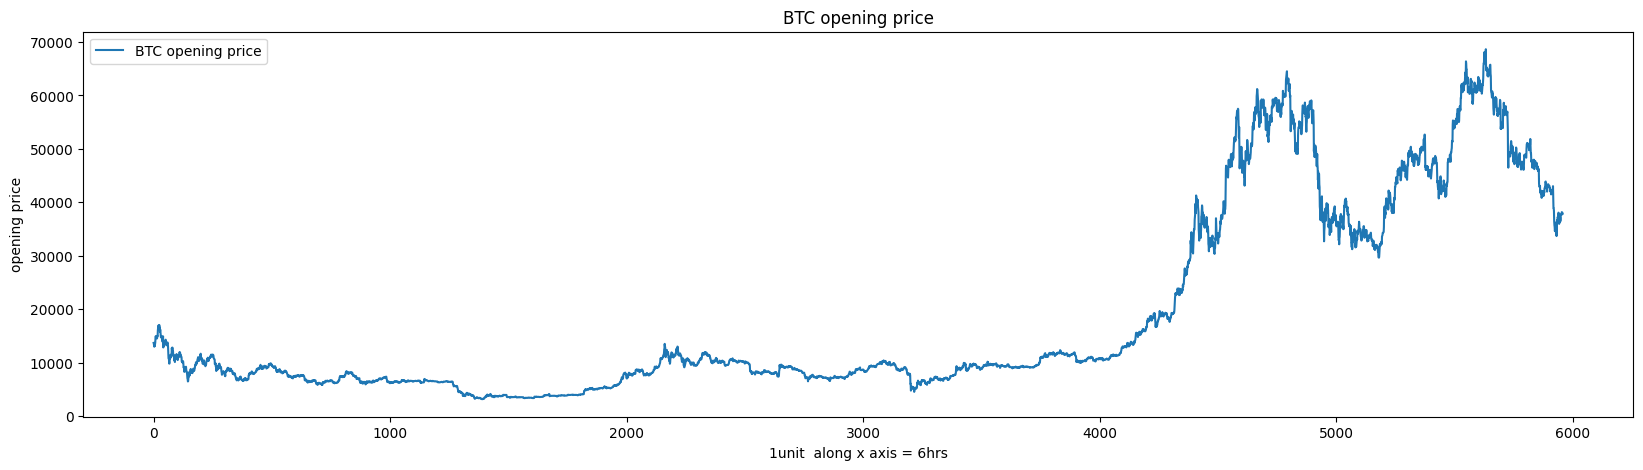

In [17]:
plot([btc_6h_open_np],'BTC opening price',['BTC opening price']    ,
    xlabel='1unit  along x axis = 6hrs',
    ylabel='opening price')

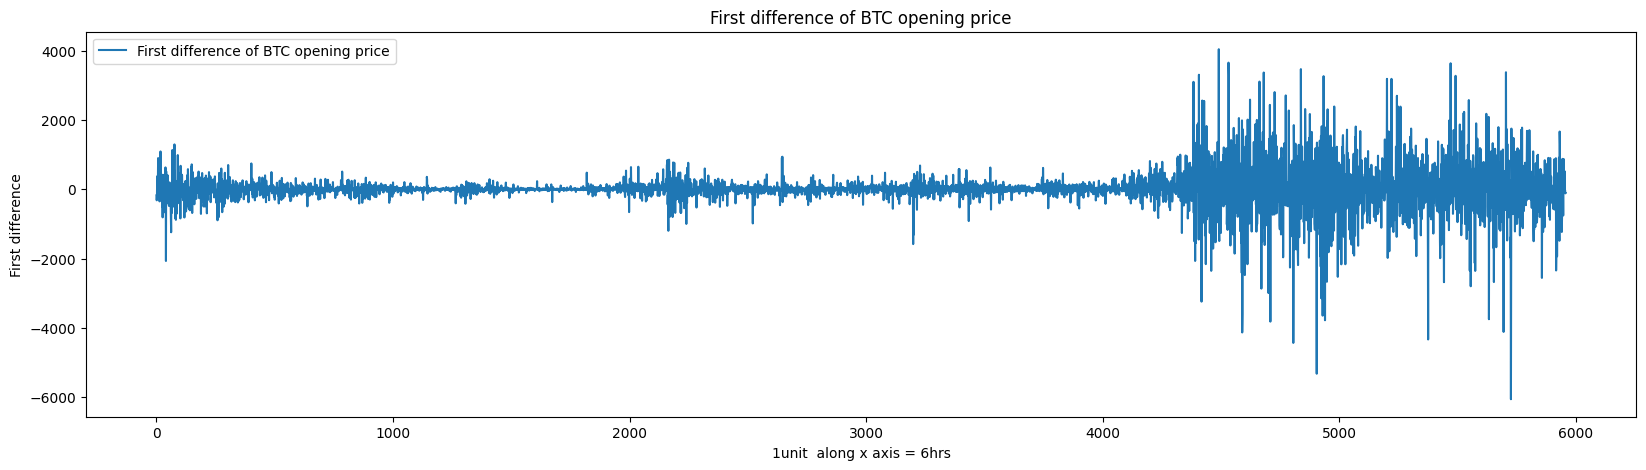

In [18]:
plot([btc_6h_open_fd_np],'First difference of BTC opening price',['First difference of BTC opening price']    ,
    xlabel='1unit  along x axis = 6hrs',
    ylabel='First difference')

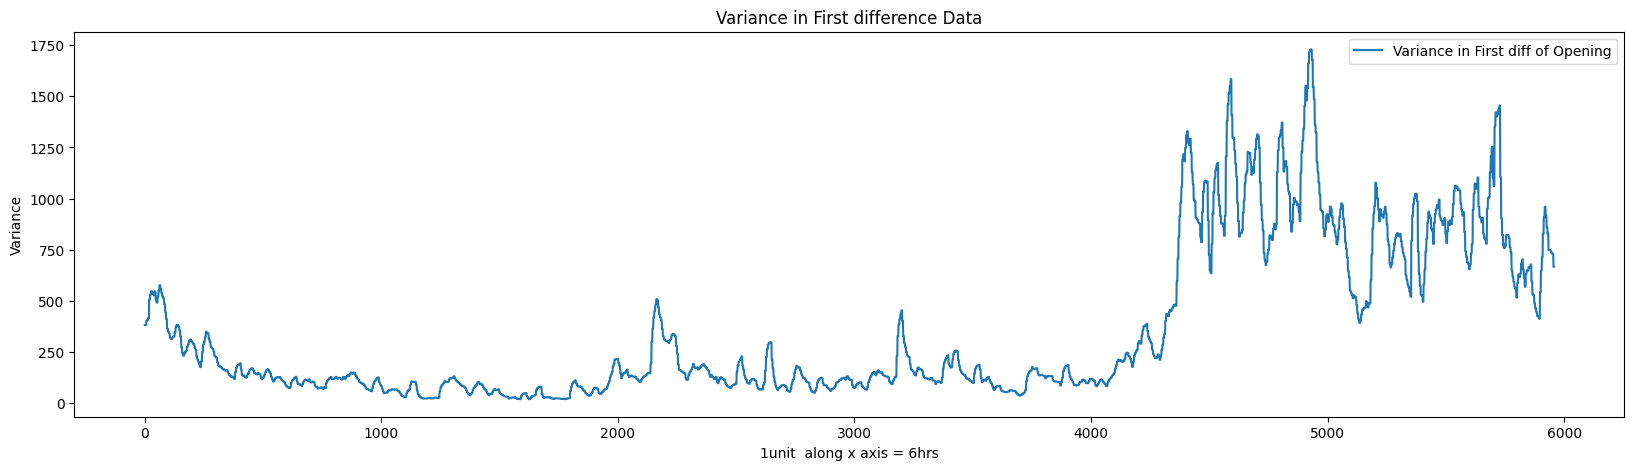

In [19]:
plot([rescale_std_6hopenfd],'Variance in First difference Data',['Variance in First diff of Opening']    ,
    xlabel='1unit  along x axis = 6hrs',
    ylabel='Variance')

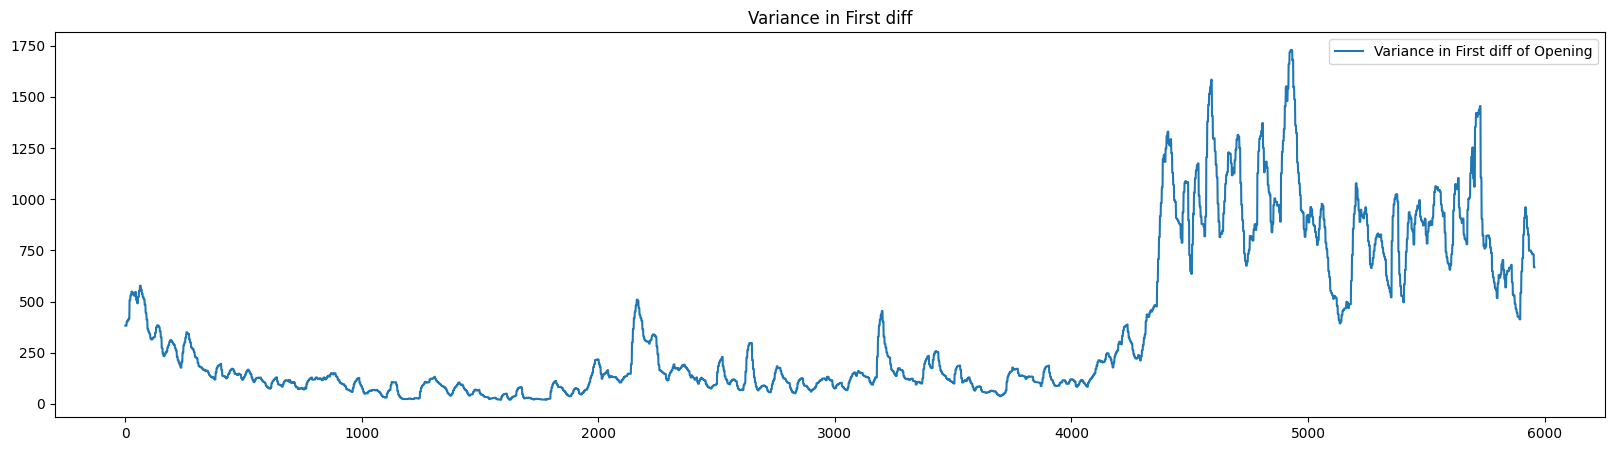

In [20]:
plot([rescale_std_6hopenfd],'Variance in First diff',['Variance in First diff of Opening'])

### Uncomment to predict Variance

In [80]:
rescale_std_6hopenfd_5d = nth_order_difference(rescale_std_6hopenfd,5)

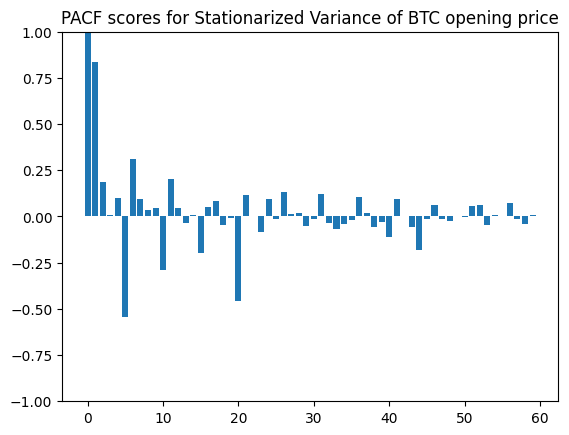

[49 50 55 42 22 54  3 14 59 19 45 30 47 57 25 27 28 37 35 48 39 13 32  8
 34 58  9 12 53 18 16 29 51 38 43 60 52 46 33 56 17 23  7 24 41  4 36 40
 21 31 26 44  2 15 11 10  6 20  5  1  0]


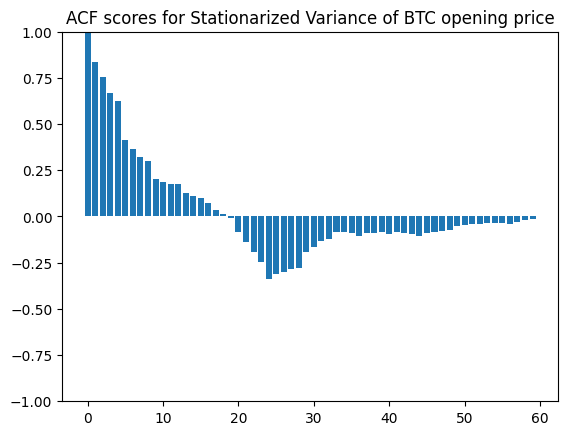

[19 60 18 59 58 57 53 17 54 55 56 52 51 50 49 16 48 47 33 46 20 39 34 41
 38 35 37 42 45 43 40 15 36 44 14 32 13 31 21 30 12 11 10 29 22  9 23 28
 27  8 26 25  7 24  6  5  4  3  2  1  0]


In [81]:
plot_pacf(rescale_std_6hopenfd_5d,num_lags=60,title="PACF scores for Stationarized Variance of BTC opening price",y_lim0=-1,y_lim1=1)
plot_acf(rescale_std_6hopenfd_5d,num_lags=60,title="ACF scores for Stationarized Variance of BTC opening price",y_lim0=-1,y_lim1=1)

In [82]:
rescale_std_6hopenfd_5d_train, rescale_std_6hopenfd_5d_test = train_test_split(rescale_std_6hopenfd_5d, splt=0.95)

In [83]:
std_arma_oder = (5,0,1)

In [84]:
arima_model = sm.tsa.arima.ARIMA(rescale_std_6hopenfd_5d_train, order=std_arma_oder)
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5655
Model:                 ARIMA(5, 0, 1)   Log Likelihood              -24622.401
Date:                Fri, 12 Jan 2024   AIC                          49260.803
Time:                        21:36:03   BIC                          49313.925
Sample:                             0   HQIC                         49279.306
                               - 5655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4345      1.760      0.247      0.805      -3.016       3.885
ar.L1          0.5220      0.010     50.036      0.000       0.502       0.542
ar.L2          0.2652      0.012     21.380      0.0

In [86]:
rescale_std_6hopenfd_test_pred = rolling_arma(data=rescale_std_6hopenfd_5d ,horizon=len(rescale_std_6hopenfd_5d_test),train_len=len(rescale_std_6hopenfd_5d_train),order=(std_arma_oder))

100%|██████████| 21/21 [03:42<00:00, 10.59s/it]


In [87]:
rescale_std_6hopenfd_test_pred_recov = rolling_recovery(rescale_std_6hopenfd, rescale_std_6hopenfd_test_pred, base_index=len(rescale_std_6hopenfd_5d_train))

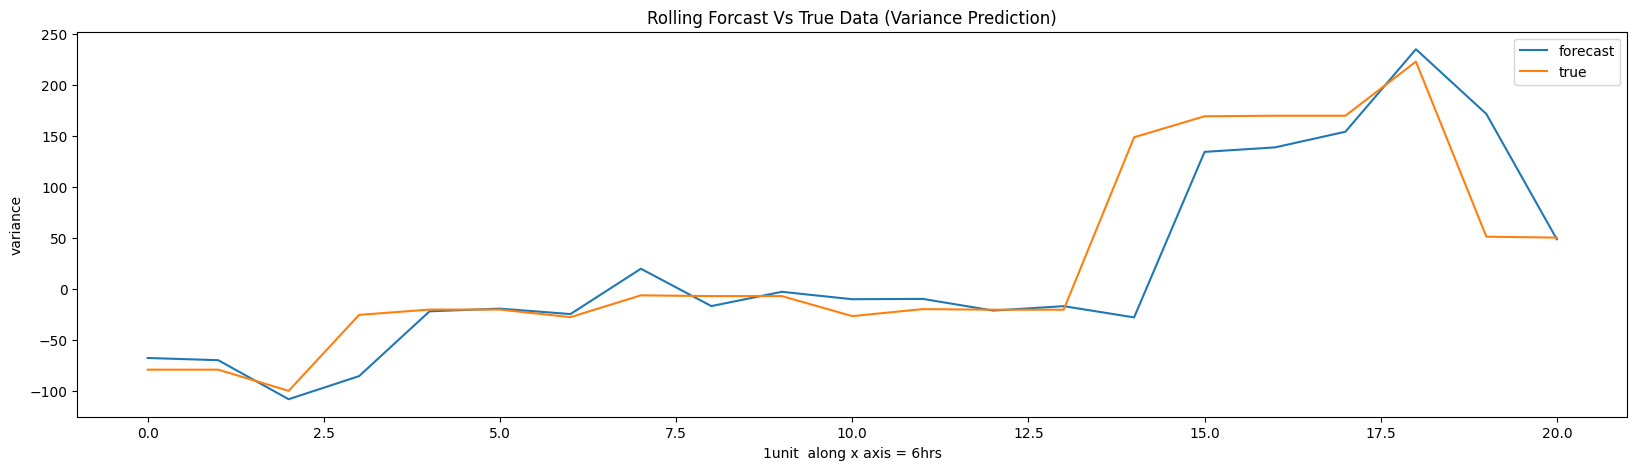

In [93]:
plot_cutoff = 21
plot(
    [
        rescale_std_6hopenfd_test_pred[:plot_cutoff],
        rescale_std_6hopenfd_5d_test[:plot_cutoff],
        # openfd_varnorm_kalman_mmnorm_test[:test_hor]
     ],'Rolling Forcast Vs True Data (Variance Prediction)',
     ['forecast',
      'true',
      # 'openfd_varnorm_lowfilt_train (filtered actual)'
      ]
    ,
    xlabel='1unit  along x axis = 6hrs',
    ylabel='variance'
    )

# Preprocessing the BTC Opening Data

In [89]:
btc_6h_openfd_varnorm_np = btc_6h_open_fd_np/rescale_std_6hopenfd

In [90]:
btc_6h_openfd_varnorm_fd_np = np.diff(btc_6h_openfd_varnorm_np)
btc_6h_openfd_varnorm_fd_mmnorm_np, max_openfd_varnorm_fd,min_openfd_varnorm_fd = normalize(btc_6h_openfd_varnorm_fd_np)

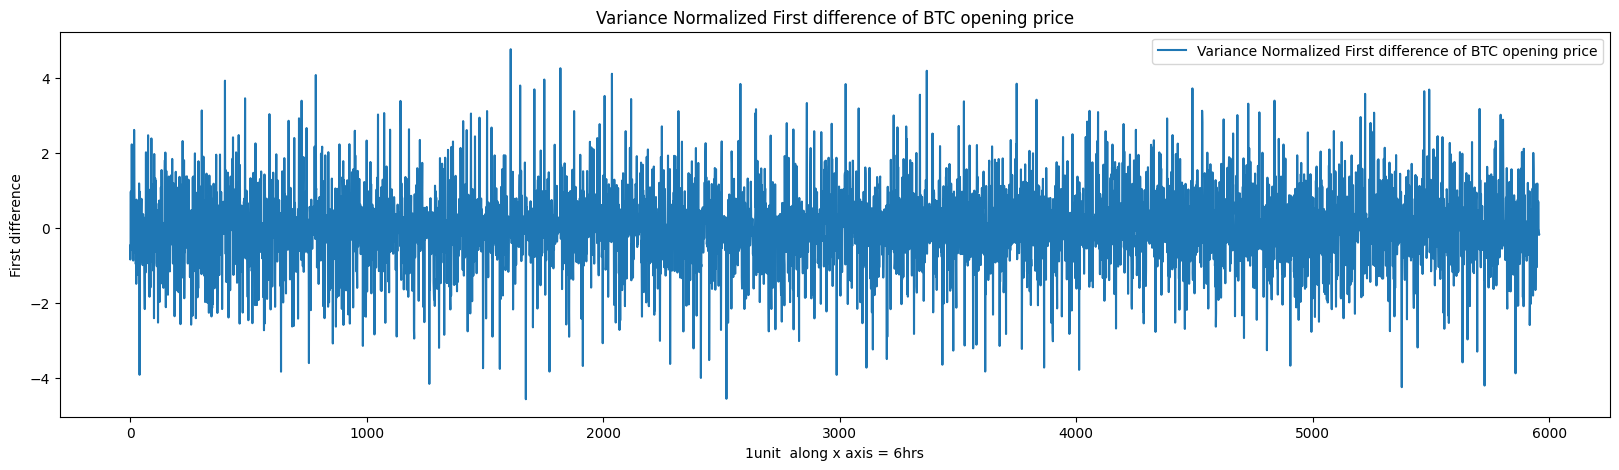

In [91]:
plot([btc_6h_openfd_varnorm_np],'Variance Normalized First difference of BTC opening price',['Variance Normalized First difference of BTC opening price']    ,
    xlabel='1unit  along x axis = 6hrs',
    ylabel='First difference')

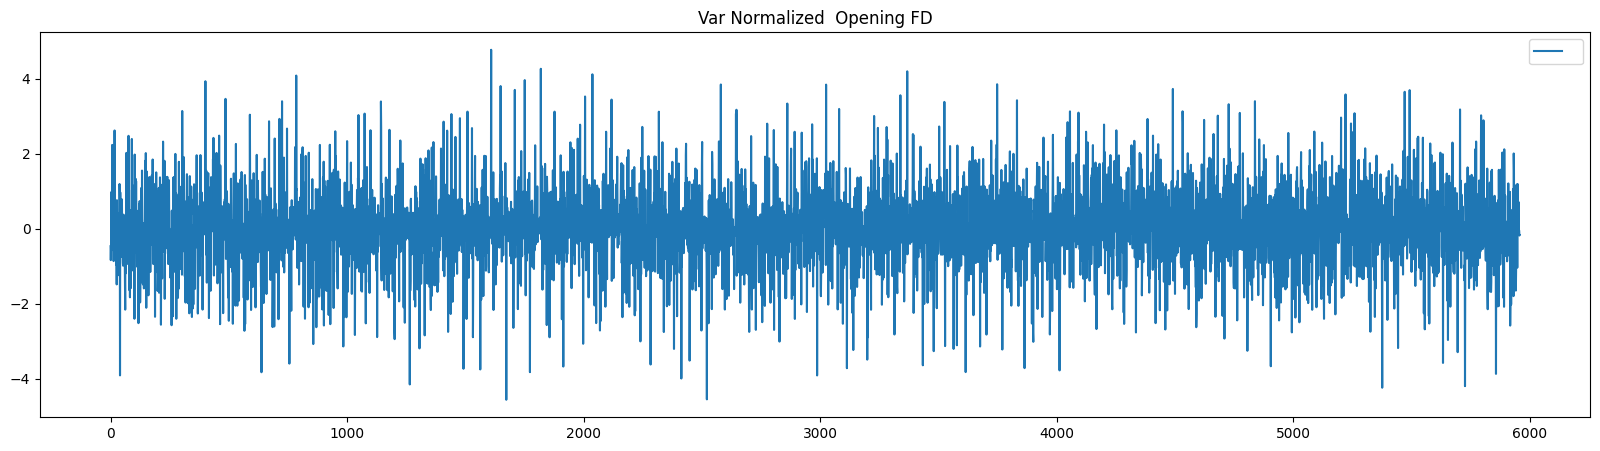

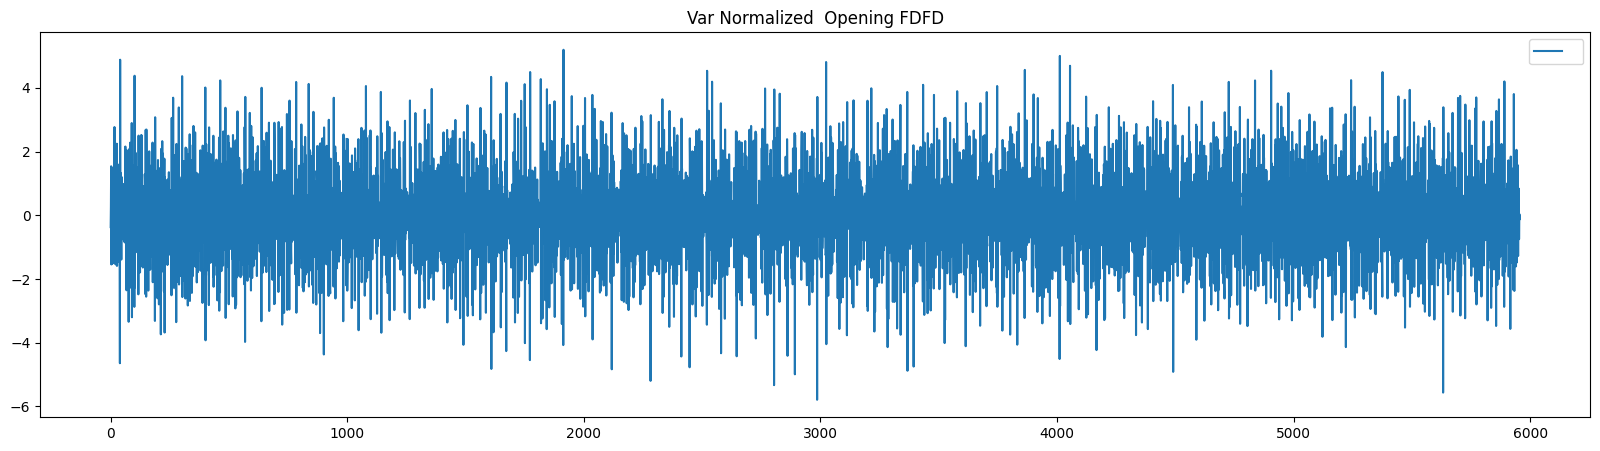

In [92]:
plot([btc_6h_openfd_varnorm_np],'Var Normalized  Opening FD',[' '])
plot([btc_6h_openfd_varnorm_fd_np],'Var Normalized  Opening FDFD',[' '])

# plot([btc_6h_volumefd_varnorm_np],'Var Normalized  Volume FD',[' '])

# Plotting the Corr Metrics of Data

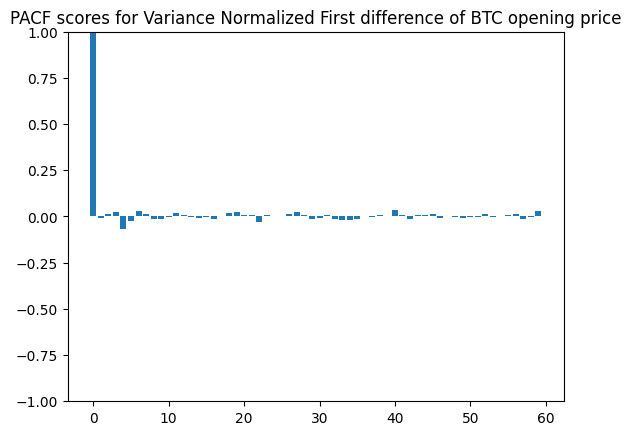

[39 36 10 58 25 53 50 24 37 48 54 15 47 51 17 13 43 20 49 30 55 21 12 31
 46 44  1 28 14 38 41 23 60 35  9  8 32 16 57 45  7 26 29  2 42 52 56 18
 33 11 34 19  3 27  5  6 59 22 40  4  0]


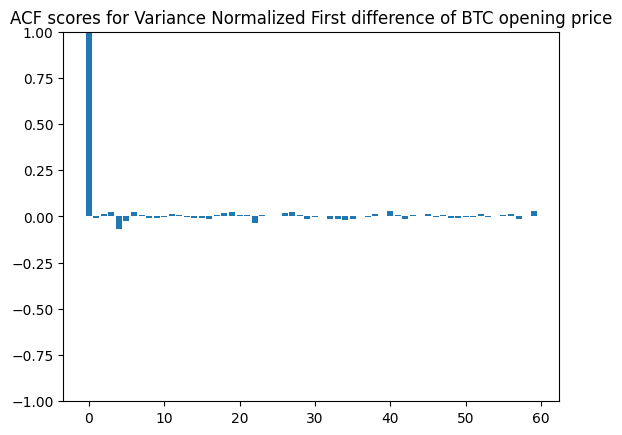

[37 36 58 24 25 50 13 46 39 51 60 10 53 31 54 44 30 17 28  9 48 47 15 43
  8 14 41 55 23 12 20  1 21  7 49 45 57 29 56 32 35 52 38 11 16  2 33 42
 18 26 34 19  3 27  5  6 59 40 22  4  0]


In [ ]:
plot_pacf(btc_6h_openfd_varnorm_np,num_lags=60,title="PACF scores for Variance Normalized First difference of BTC opening price",y_lim0=-1,y_lim1=1)
plot_acf(btc_6h_openfd_varnorm_np,num_lags=60,title="ACF scores for Variance Normalized First difference of BTC opening price",y_lim0=-1,y_lim1=1)

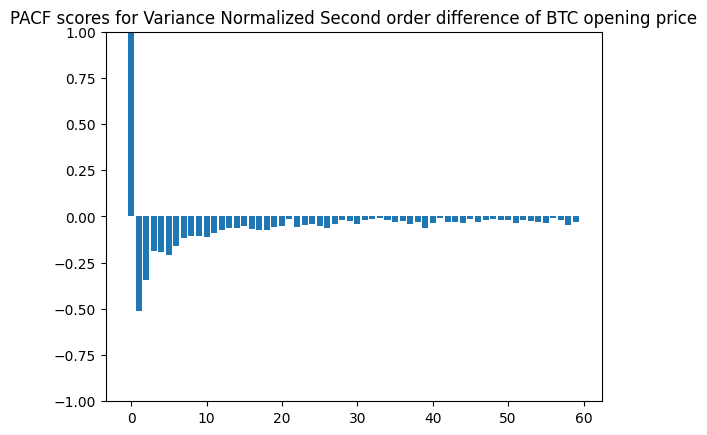

[56 41 33 32 21 45 48 60 50 57 28 52 31 47 49 34 53 29 36 46 54 38 59 42
 35 43 55 40 51 44 37 30 27 24 23 58 25 15 20 22 19 26 39 13 14 16 12 17
 18 11  9  8 10  7  6  3  4  5  2  1  0]


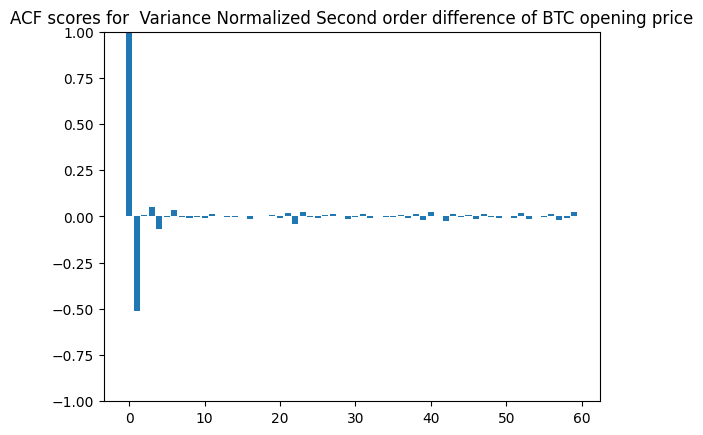

[41 28  7  9 30 33 55 12 13  5 14 54 24 18 17 44 34 15 48 50 35 26 49 58
  2 20 36 37 25 10  8 32 60 45 19 51 47 46 27 43 29 11 38 53 31 16 56 52
 57 39 21 42 23 59 40  6 22  3  4  1  0]


In [ ]:
plot_pacf(btc_6h_openfd_varnorm_fd_np,num_lags=60,title="PACF scores for Variance Normalized Second order difference of BTC opening price",y_lim0=-1,y_lim1=1)
plot_acf(btc_6h_openfd_varnorm_fd_np,num_lags=60,title="ACF scores for  Variance Normalized Second order difference of BTC opening price",y_lim0=-1,y_lim1=1)

# BTC Modeling

In [ ]:
fdfd_date_np = np.array(btc_6h_df['datetime'][1:][1:])
fd_date_np = np.array(btc_6h_df['datetime'][1:])

In [ ]:
openfd_varnorm_fd_train, openfd_varnorm_fd_test = train_test_split(btc_6h_openfd_varnorm_fd_np,splt=0.95)
openfd_varnorm_train, openfd_varnorm_test = train_test_split(btc_6h_openfd_varnorm_np,splt=0.95)

fdfd_date_np_train, fdfd_date_np_test = train_test_split(fdfd_date_np,splt=0.95)
fd_date_np_train, fd_date_np_test = train_test_split(fd_date_np,splt=0.95)


assert openfd_varnorm_fd_test.shape == openfd_varnorm_test.shape

In [ ]:
check_stationarity(openfd_varnorm_fd_train)

ADF Statistic: -23.429114432024726
p-value: 0.0
Critical Values:
	1%: -3.431577246585554
	5%: -2.8620823176948718
	10%: -2.567058675092483


In [ ]:
arma_oder = (6,0,4)
arima_model = sm.tsa.arima.ARIMA(openfd_varnorm_fd_train, order=arma_oder)
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5361
Model:                 ARIMA(6, 0, 4)   Log Likelihood               -7597.912
Date:                Thu, 11 Jan 2024   AIC                          15219.824
Time:                        22:58:50   BIC                          15298.866
Sample:                             0   HQIC                         15247.429
                               - 5361                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.105e-05    2.1e-05      0.525      0.600   -3.02e-05    5.23e-05
ar.L1         -1.7845      0.095    -18.697      0.000      -1.972      -1.597
ar.L2         -1.5877      0.137    -11.627      0.0

In [ ]:
var_forecast = arima_model_fit.forecast(steps=30)#*(max_data_train-min_data_train)

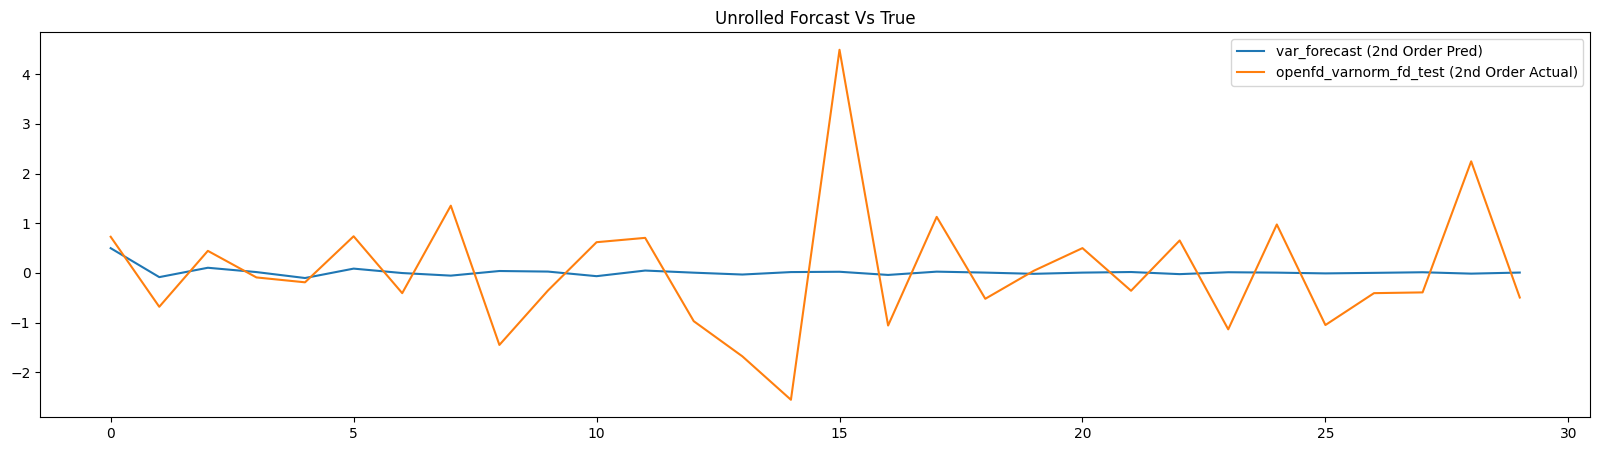

In [ ]:
plot_cutoff = 30
plot(
    [var_forecast[:plot_cutoff],
    # openfd_varnorm_mmnorm_test[:plot_cutoff],
    openfd_varnorm_fd_test[:plot_cutoff]
     ],
    'Unrolled Forcast Vs True',
     ['var_forecast (2nd Order Pred)',
      # 'openfd_varnorm_test (Unfiltered actual)',
      'openfd_varnorm_fd_test (2nd Order Actual)'])

In [ ]:
test_hor = len(openfd_varnorm_test)
btc_rolling_predictions_arma = rolling_arma(data=btc_6h_openfd_varnorm_fd_np,horizon=test_hor,train_len=len(openfd_varnorm_fd_train),order=arma_oder)
btc_rolling_predictions_ma = rolling_MA(data=btc_6h_openfd_varnorm_fd_np,horizon=test_hor,train_len=len(openfd_varnorm_fd_train),window=1)

In [ ]:
btc_rolling_unnorm_fdfd_predictions_arma = btc_rolling_predictions_arma[:test_hor]#unnormalize (btc_rolling_mmnorm_predictions_arma[:test_hor], max_openfd_varnorm_lowfilt,min_openfd_varnorm_lowfilt)
openfd_varnorm_fd_unnorm_test =  openfd_varnorm_fd_test[:test_hor]#unnormalize (openfd_varnorm_kalman_mmnorm_test[:test_hor], max_openfd_varnorm,min_openfd_varnorm)
# openfd_varnorm_unnorm_test = unnormalize (openfd_varnorm_mmnorm_test[:test_hor], max_openfd_varnorm_kalman,min_openfd_varnorm_kalman)

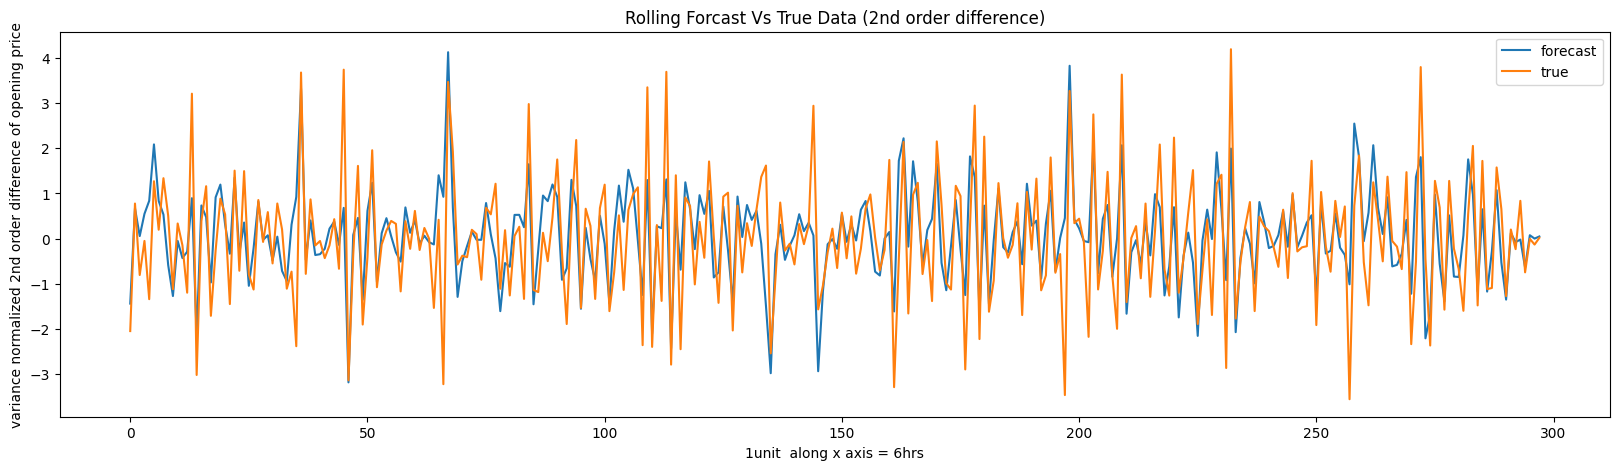

In [ ]:
plot_cutoff = test_hor
plot(
    [
        btc_rolling_unnorm_fdfd_predictions_arma,
        openfd_varnorm_fd_unnorm_test,
        # openfd_varnorm_kalman_mmnorm_test[:test_hor]
     ],'Rolling Forcast Vs True Data (2nd order difference)',
     ['forecast',
      'true',
      # 'openfd_varnorm_lowfilt_train (filtered actual)'
      ]
    ,
    xlabel='1unit  along x axis = 6hrs',
    ylabel='variance normalized 2nd order difference of opening price'
    )

In [ ]:
np.sum((btc_rolling_unnorm_fdfd_predictions_arma-openfd_varnorm_fd_unnorm_test)**2)/test_hor

0.9778538175847817

In [ ]:
np.save('2nd_order_v1_95colonFull.npy',btc_rolling_unnorm_fdfd_predictions_arma)
np.save('2nd_orderdate_v1_95colonFull.npy',fdfd_date_np_test[:test_hor])

In [ ]:
btc_rolling_unnorm_fdfd_predictions_arma_varunnorm = btc_rolling_unnorm_fdfd_predictions_arma*rescale_std_6hopenfd_test
openfd_varnorm_fd_unnorm_test_varunnorm = openfd_varnorm_fd_unnorm_test*rescale_std_6hopenfd_test

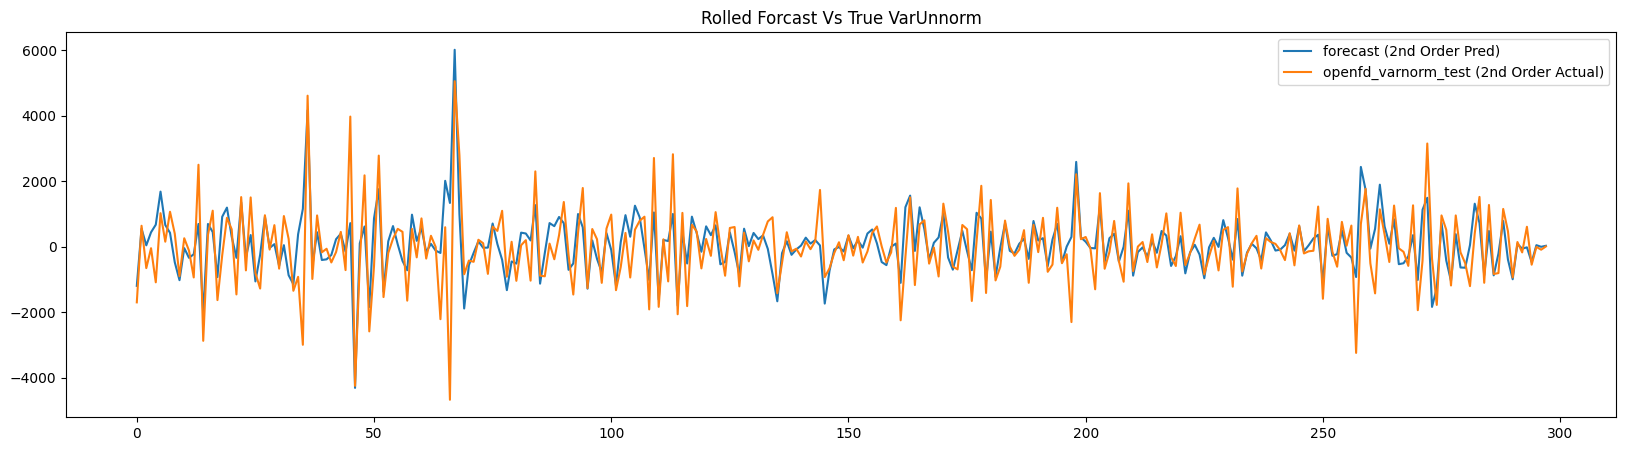

In [ ]:
plot_cutoff = test_hor
plot(
    [
        btc_rolling_unnorm_fdfd_predictions_arma_varunnorm,
        openfd_varnorm_fd_unnorm_test_varunnorm,
        # openfd_varnorm_kalman_mmnorm_test[:test_hor]
     ],'Rolled Forcast Vs True VarUnnorm',
     ['forecast (2nd Order Pred)',
      'openfd_varnorm_test (2nd Order Actual)',
      # 'openfd_varnorm_lowfilt_train (filtered actual)'
      ])

In [ ]:
compute_misclass(
    true=btc_rolling_unnorm_fdfd_predictions_arma,
    pred=openfd_varnorm_fd_unnorm_test,
    thr=0.9)

Before thresholding
Mismatched 70/298
Matched 228/298
After thresholding
+ve Mismatched 2/3
-ve Mismatched 1/3
Mismatched 3/298  (1.006711409395973%)
Matched 71/298
Low conf 224/298


In [ ]:
compute_misclass(
    true=btc_rolling_unnorm_fdfd_predictions_arma_varunnorm,
    pred=openfd_varnorm_fd_unnorm_test_varunnorm,
    thr=200)

Before thresholding
Mismatched 70/298
Matched 228/298
After thresholding
+ve Mismatched 15/26
-ve Mismatched 11/26
Mismatched 26/298  (8.724832214765101%)
Matched 160/298
Low conf 112/298


In [ ]:
np.save('/content/drive/MyDrive/btc_king/stdroll_v1_95colonFull.npy',rescale_std_6hopenfd_test)

 ## Recovering 1st order from 2nd order

In [ ]:
openfd_varnorm_unnorm_test_recov = rolling_recovery(btc_6h_openfd_varnorm_np, openfd_varnorm_fd_unnorm_test, base_index = len(openfd_varnorm_train)-1)
btc_rolling_unnorm_fd_predictions_arma_recov = rolling_recovery(btc_6h_openfd_varnorm_np, btc_rolling_unnorm_fdfd_predictions_arma, base_index = len(openfd_varnorm_train)-1)

btc_rolling_unnorm_fd_predictions_arma_power_recov = btc_rolling_unnorm_fd_predictions_arma_recov*np.abs((btc_rolling_unnorm_fdfd_predictions_arma/4))

In [ ]:
np.save('1st_order_v1_95colonFull.npy',btc_rolling_unnorm_fdfd_predictions_arma)
np.save('1st_orderdate_v1_95colonFull.npy',fd_date_np_test[:test_hor])

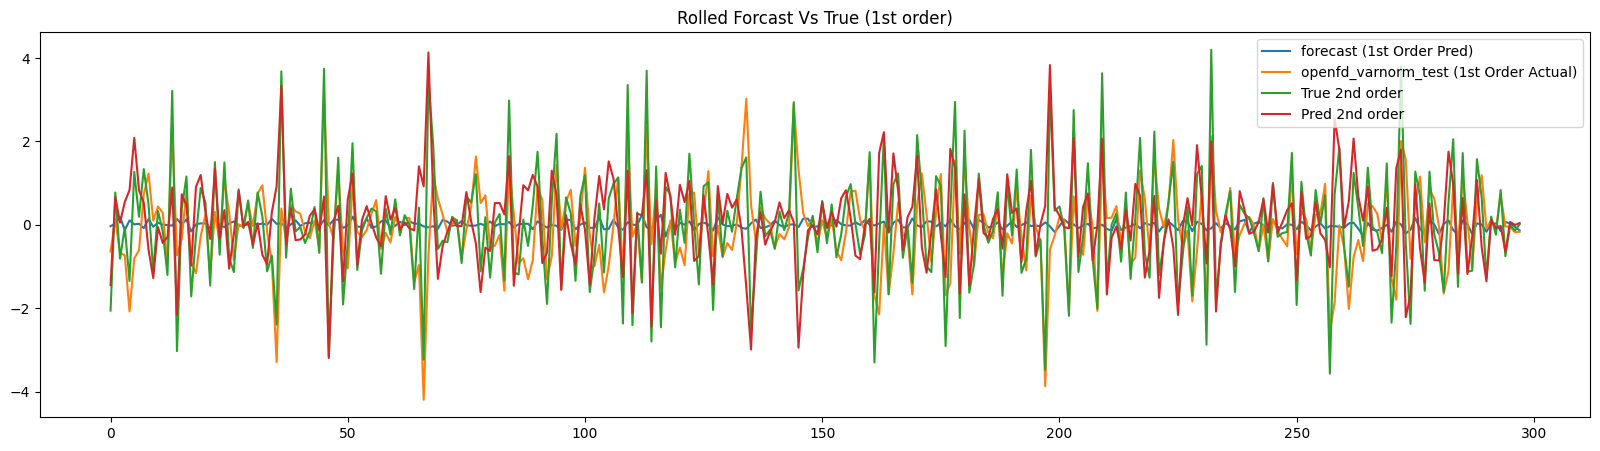

In [ ]:
plot(
    [
        btc_rolling_unnorm_fd_predictions_arma_recov[:test_hor],
        # openfd_varnorm_unnorm_test_recov[:test_hor],
        openfd_varnorm_test[:test_hor],
        openfd_varnorm_fd_unnorm_test,
        btc_rolling_unnorm_fdfd_predictions_arma
     ],'Rolled Forcast Vs True (1st order)',
     ['forecast (1st Order Pred)',
      # 'openfd_varnorm_unnorm_test_recov (1st Order Actual Rec)',
      'openfd_varnorm_test (1st Order Actual)',
      'True 2nd order',
      'Pred 2nd order'
      ])

In [ ]:
error_ratio_2nd = openfd_varnorm_fd_unnorm_test/btc_rolling_unnorm_fdfd_predictions_arma
plot(
    [error_ratio_2nd],'error_ratio_1st',[''],y_lim=(-5,5)
)

In [ ]:
compute_misclass(true=openfd_varnorm_unnorm_test_recov,pred=btc_rolling_unnorm_fd_predictions_arma_recov,thr=0.1)

Before thresholding
Mismatched 11/20
Matched 9/20
After thresholding
+ve Mismatched 3/11
-ve Mismatched 8/11
Mismatched 11/20  (55.00000000000001%)
Matched 9/20
Low conf 0/20
